# Prévision des risques comportementaux et émotionnels chez les patients

**Contexte :**
Une clinique de santé mentale souhaite améliorer sa capacité à prédire les risques de troubles comportementaux et émotionnels chez ses jeunes patients. En tant que data scientist, vous êtes chargé de développer un modèle de prévision utilisant les données collectées.

**Objectifs :**
1. **Prévoir les Risques de Troubles Comportementaux et Émotionnels :** Utiliser les données disponibles pour prédire les scores de problèmes émotionnels (emotional_SDQ), de conduite (cond_SDQ), d'hyperactivité (hyper_SDQ), et de problèmes avec les pairs (pairs_SDQ).
2. **Identifier les Facteurs Déterminants :** Analyser les variables les plus influentes pour chaque type de trouble.


## Importation des bibliothèques 


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold

## Importation du jeu de données

In [6]:
# imortation du jeu de données au format csv
cherckup=pd.read_stata(r'c:\Users\ARMIDE Informatique\Desktop\Formation pratique\neerspss-français.dta')

cherckup

,index,participant,__ge,_sexe,_SDQ_TotaleProblematics,_SDQ_Subscale_EmotionalProblems,_SDQ_Subscale_ConductProblems,_Problemes_SDQ_Subscale_Hyperact,_SDQ_Subscale_ProblemsPeers,_SDQ_Subscale_Comportement_proso,_KSADS_Symptoms_ODD_TSCORE,_KSADS_Diagnosis_ADHD,_CPRS_RL_A
0,0,19-1-1103,12.92,Homme,5,2,0,3,0,9,54,non,3
1,1,19-105-10017,13.56,Homme,14,2,2,10,0,7,83,Oui,4
2,2,19-112-10048,16.27,Homme,27,6,8,10,3,6,90,Oui,5
3,3,19-125-10102,14.74,Homme,22,4,3,8,7,4,65,non,5
4,4,19-129-10118,15.75,Homme,20,2,4,9,5,5,64,Oui,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,99,98-843-80206,11.54,femme,15,8,0,4,3,9,90,Oui,2
100,100,98-845-80212,17.21,femme,12,5,2,5,0,7,72,non,2
101,101,98-847-80218,12.67,femme,17,2,4,10,1,9,90,Oui,4
102,102,98-848-80221,12.91,femme,23,6,8,8,1,9,90,Oui,3


## 1. Analyse exploratoire des données 

### 1.1. Détection des outliers et des valeurs manquantes

 Les doublons sont : 0


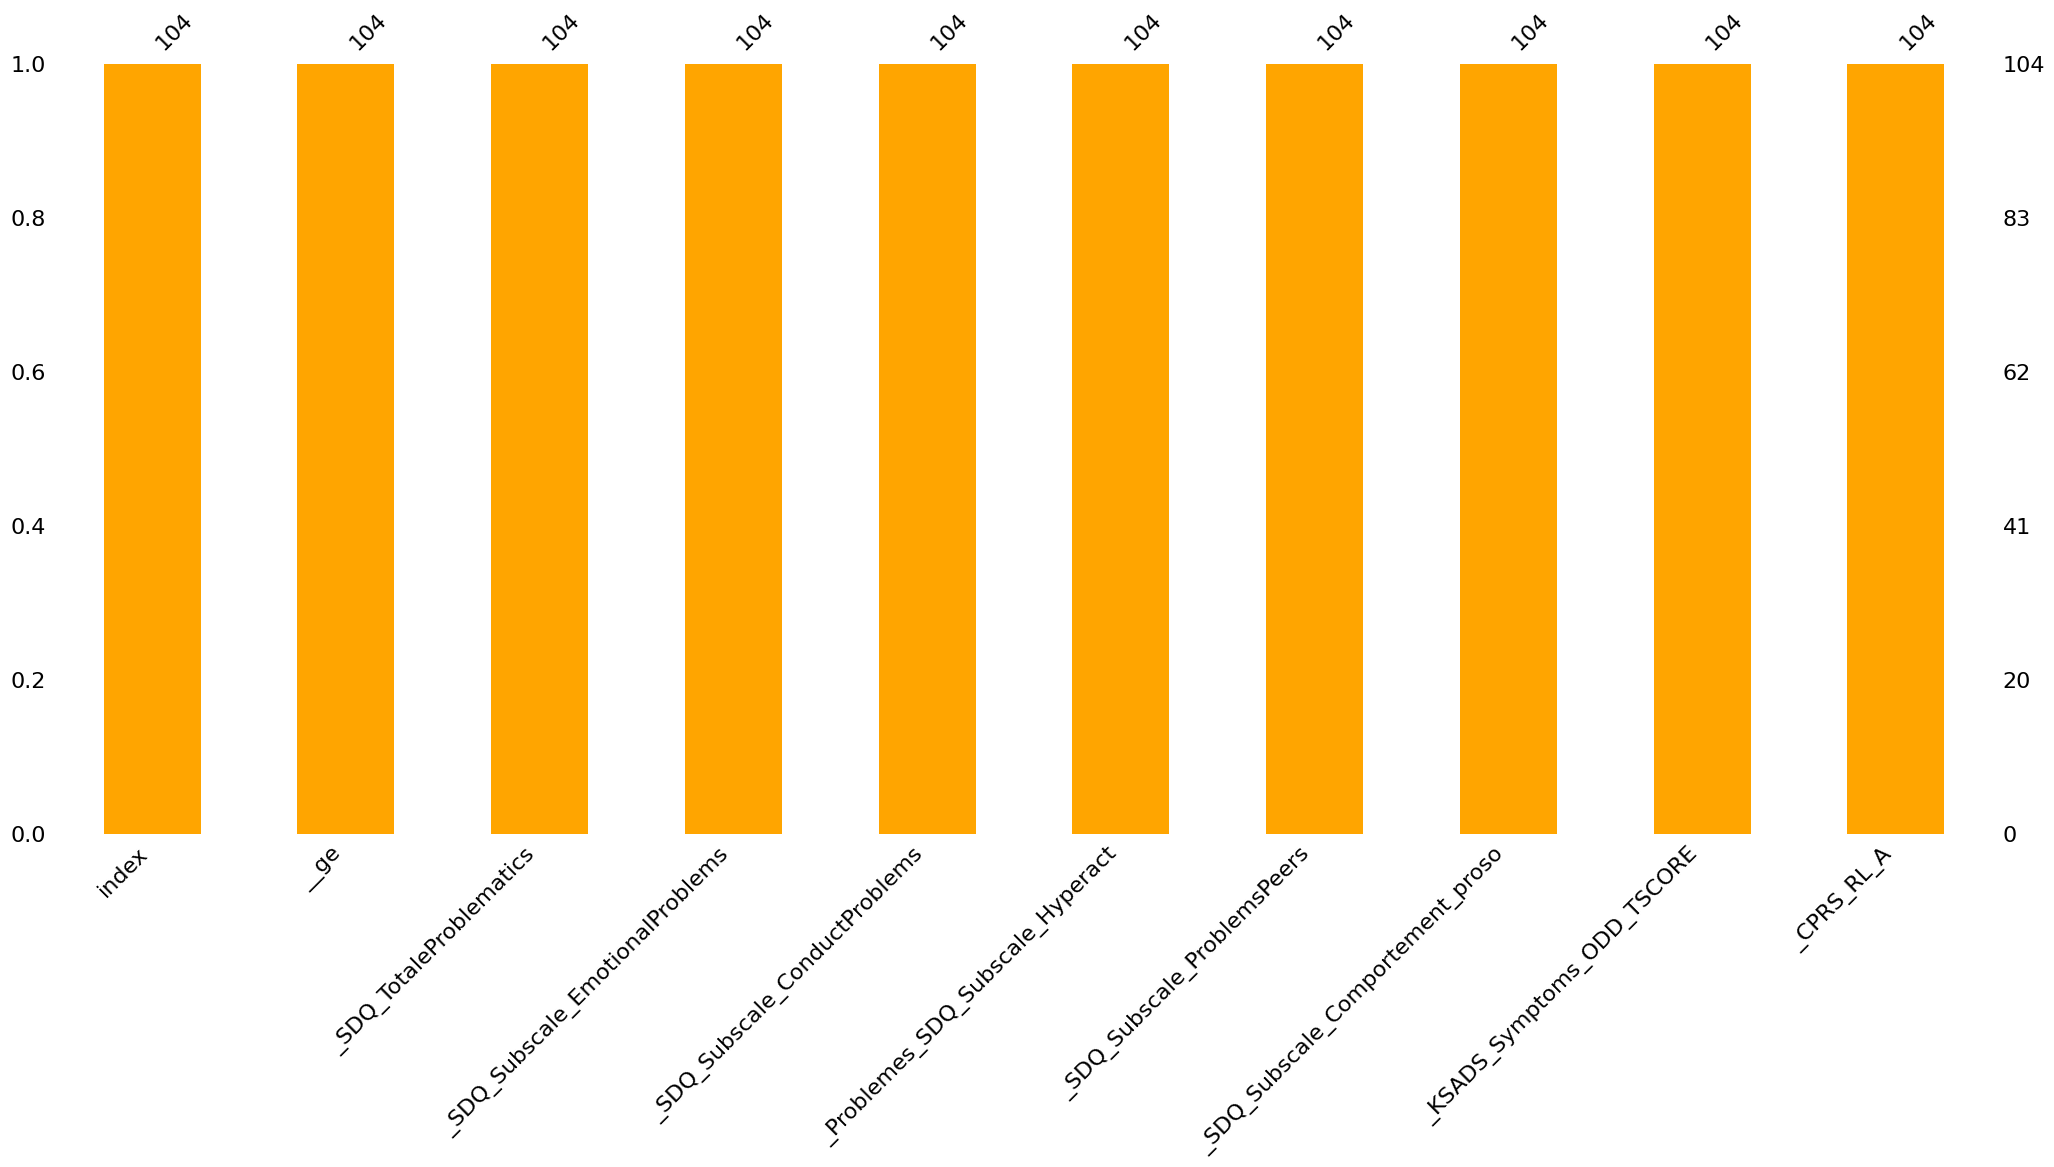

In [7]:
# redéfinition de la base de données
emo= cherckup.select_dtypes(exclude=["object"])
emo #affichage du résultats


# affichage des données manquantes
import missingno as msno
msno.bar(emo, color='orange')

# affichage des doublons
print(' Les doublons sont :', emo.duplicated().sum())


,index,__ge,_SDQ_TotaleProblematics,_SDQ_Subscale_EmotionalProblems,_SDQ_Subscale_ConductProblems,_Problemes_SDQ_Subscale_Hyperact,_SDQ_Subscale_ProblemsPeers,_SDQ_Subscale_Comportement_proso,_KSADS_Symptoms_ODD_TSCORE,_CPRS_RL_A
7,7,15.13,37,9,8,10,10,6,90,8
9,9,15.59,21,4,4,10,3,1,90,1
34,34,11.52,32,10,2,10,10,10,90,3
53,53,13.45,26,6,3,7,10,4,90,4
57,57,14.81,9,0,3,4,2,1,90,7
69,69,15.67,31,6,7,8,10,4,85,6
92,92,10.10,26,5,5,10,6,1,90,3


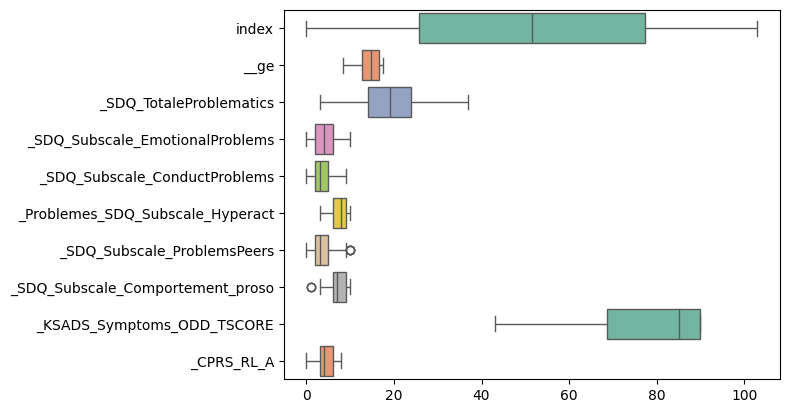

In [8]:
# détection des valeurs aberrantes graphiques 
sns.boxplot(data=emo, orient="h", palette="Set2")

# avec la méthode IQR
Q1 = emo.quantile(0.25)
Q3 = emo.quantile(0.75)
IQR = Q3-Q1

outliers=((emo<(Q1-1.5*IQR))|(emo >(Q3+1.5*IQR)))
valeurs_aberrantes=emo[outliers.any(axis=1)]
valeurs_aberrantes #affichage des résultats

In [9]:
# supression des valeurs abérrantes dans le jeu de donnes

emo = emo.drop(valeurs_aberrantes.index)

emo

,index,__ge,_SDQ_TotaleProblematics,_SDQ_Subscale_EmotionalProblems,_SDQ_Subscale_ConductProblems,_Problemes_SDQ_Subscale_Hyperact,_SDQ_Subscale_ProblemsPeers,_SDQ_Subscale_Comportement_proso,_KSADS_Symptoms_ODD_TSCORE,_CPRS_RL_A
0,0,12.92,5,2,0,3,0,9,54,3
1,1,13.56,14,2,2,10,0,7,83,4
2,2,16.27,27,6,8,10,3,6,90,5
3,3,14.74,22,4,3,8,7,4,65,5
4,4,15.75,20,2,4,9,5,5,64,4
...,...,...,...,...,...,...,...,...,...,...
99,99,11.54,15,8,0,4,3,9,90,2
100,100,17.21,12,5,2,5,0,7,72,2
101,101,12.67,17,2,4,10,1,9,90,4
102,102,12.91,23,6,8,8,1,9,90,3


Les premiers pré-traitements éffectués sur le jeu de données montre qu'il ne contient ni de valeurs manquantes, ni de doublons. Ce qui commence par bien avancer notre étude. 

Par contre, le graphique du diagramme de moustache et la méthode IQR utilisés montrent qu'il existe bel et bien des valeurs abérantes susceptibles de compromettres notre modélisation. Pour améliorer ainsi nos résultats, nous avons supprimé ces outliers.

Passons maintenant à la statistique descriptive, la matrice de corrélation et les relations entre les variables.

In [10]:
# supreesion de quelques variables dans le jeu de données
emo = emo.drop(columns=['_SDQ_Subscale_Comportement_proso', '_KSADS_Symptoms_ODD_TSCORE','_CPRS_RL_A','index'])

emo

,__ge,_SDQ_TotaleProblematics,_SDQ_Subscale_EmotionalProblems,_SDQ_Subscale_ConductProblems,_Problemes_SDQ_Subscale_Hyperact,_SDQ_Subscale_ProblemsPeers
0,12.92,5,2,0,3,0
1,13.56,14,2,2,10,0
2,16.27,27,6,8,10,3
3,14.74,22,4,3,8,7
4,15.75,20,2,4,9,5
...,...,...,...,...,...,...
99,11.54,15,8,0,4,3
100,17.21,12,5,2,5,0
101,12.67,17,2,4,10,1
102,12.91,23,6,8,8,1


### 1.2. Statistique descriptive

In [11]:
#statistique descriptive
statistique_emo = emo.describe()
statistique_emo

,__ge,_SDQ_TotaleProblematics,_SDQ_Subscale_EmotionalProblems,_SDQ_Subscale_ConductProblems,_Problemes_SDQ_Subscale_Hyperact,_SDQ_Subscale_ProblemsPeers
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,14.294330,18.546392,4.103093,3.597938,7.463918,3.381443
std,2.415546,5.986131,2.804329,2.285187,1.958219,2.489324
min,8.290000,3.000000,0.000000,0.000000,3.000000,0.000000
25%,12.670000,14.000000,2.000000,2.000000,6.000000,1.000000
50%,14.740000,19.000000,4.000000,3.000000,8.000000,3.000000
75%,16.520000,23.000000,6.000000,5.000000,9.000000,5.000000
max,17.420000,30.000000,10.000000,9.000000,10.000000,9.000000


### 1.3. Matrice de corrélation

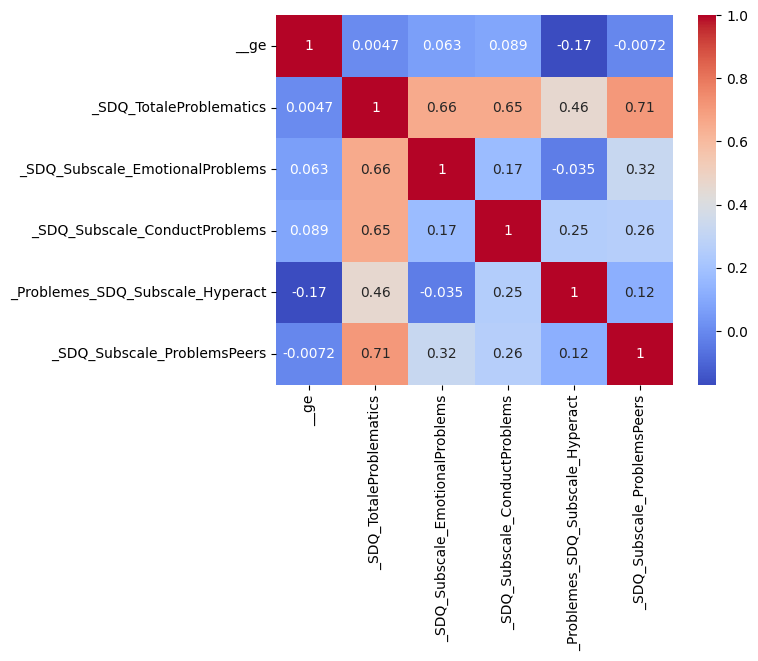

In [12]:
# matrice de corrélation
correlation_emo = emo.corr()
sns.heatmap(correlation_emo, annot=True, cmap="coolwarm")
plt.show()

Pour cette étude, nous avons choisi 07 prédicteurs plus parlants qui nous seront très utiles dans notre modélisation. Nous avons donc : 

Bien sûr, voici six prédicteurs que vous pouvez utiliser pour prédire le score total SDQ (`total_SDQ`):

- **`__ge`** : Âge du patient
- **`_SDQ_Subscale_EmotionalProblems`** : Score de problèmes émotionnels SDQ
- **`_SDQ_Subscale_ConductProblems`** : Score de problèmes de conduite SDQ
- **`_Problemes_SDQ_Subscale_Hyperact`** : Score de problèmes d'hyperactivité SDQ
- **`_SDQ_Subscale_ProblemsPeers`** : Score de problèmes avec les pairs SDQ

Ces prédicteurs sont choisis car ils couvrent divers aspects des troubles comportementaux et émotionnels et sont susceptibles d'avoir une influence significative sur le score total SDQ (***'_SDQ_TotaleProblematics'***), notre variable cible.

#### ***Interprétation de la matrice de corrélation***

La matrice de corrélation réalisée montre qu'avec notre variable cibkle :
- **`_SDQ_Subscale_EmotionalProblems`** :le score de problèmes émotionnels SDQ présente aussi une forte corrélation positive (0.66)
- **`_SDQ_Subscale_ConductProblems`** : le score de problèmes de conduite SDQ présente aussi une forte corrélation positive (0.65)
- **`_Problemes_SDQ_Subscale_Hyperact`** : le score de problèmes d'hyperactivité SDQ orésente aussi une  légère corrélation positive (0.46)
- **`_SDQ_Subscale_ProblemsPeers`** : Le score de problèmes avec les pairs présente une forte corrélation postive (0.72)
- **`__ge`** : l'âge des patients présente une très légère corrélation positive (0,0047).

Au vue de ces résultats, on peut alors conclure que : 
le score de problèmes avec les pairs est plus prédictif que le score de problèmes émtionnels. Tandis que le scire de problème émotionnels est plus prédictif que le score de problème de conduite, qui lui est plus prédictif que le score de problème d'hyperactivité. Enfin, ce score qui est plus prédictif que l'age des patients. 

Alors l'âge des patients n'est pas un facteur qui peut influencer le risque des problèmes comportementaux et émotionnels chez les patients.

### 1.4. Relation graphique avec la cible et les prédicteurs

c:\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\P

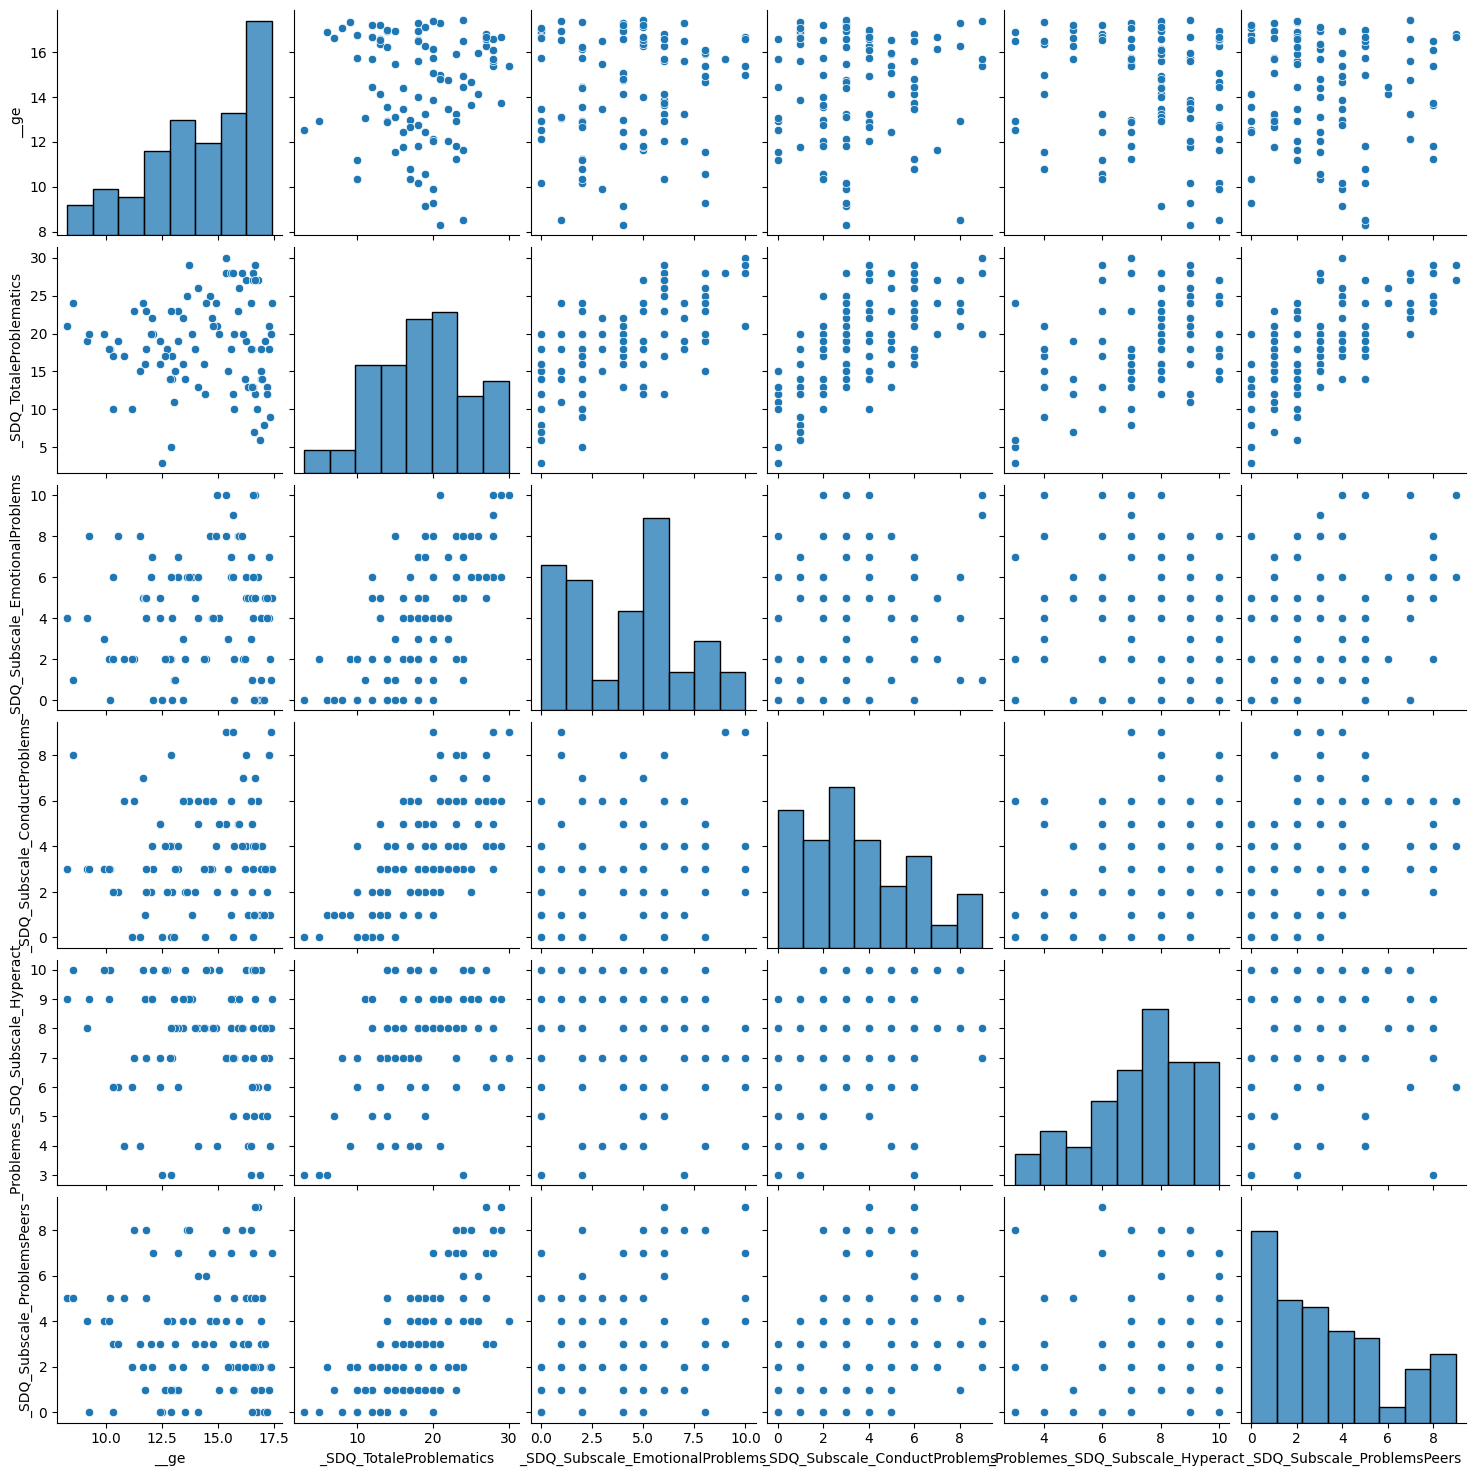

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

#visualisation de la base de données
sns.pairplot(emo, palette="husl")
plt.show()

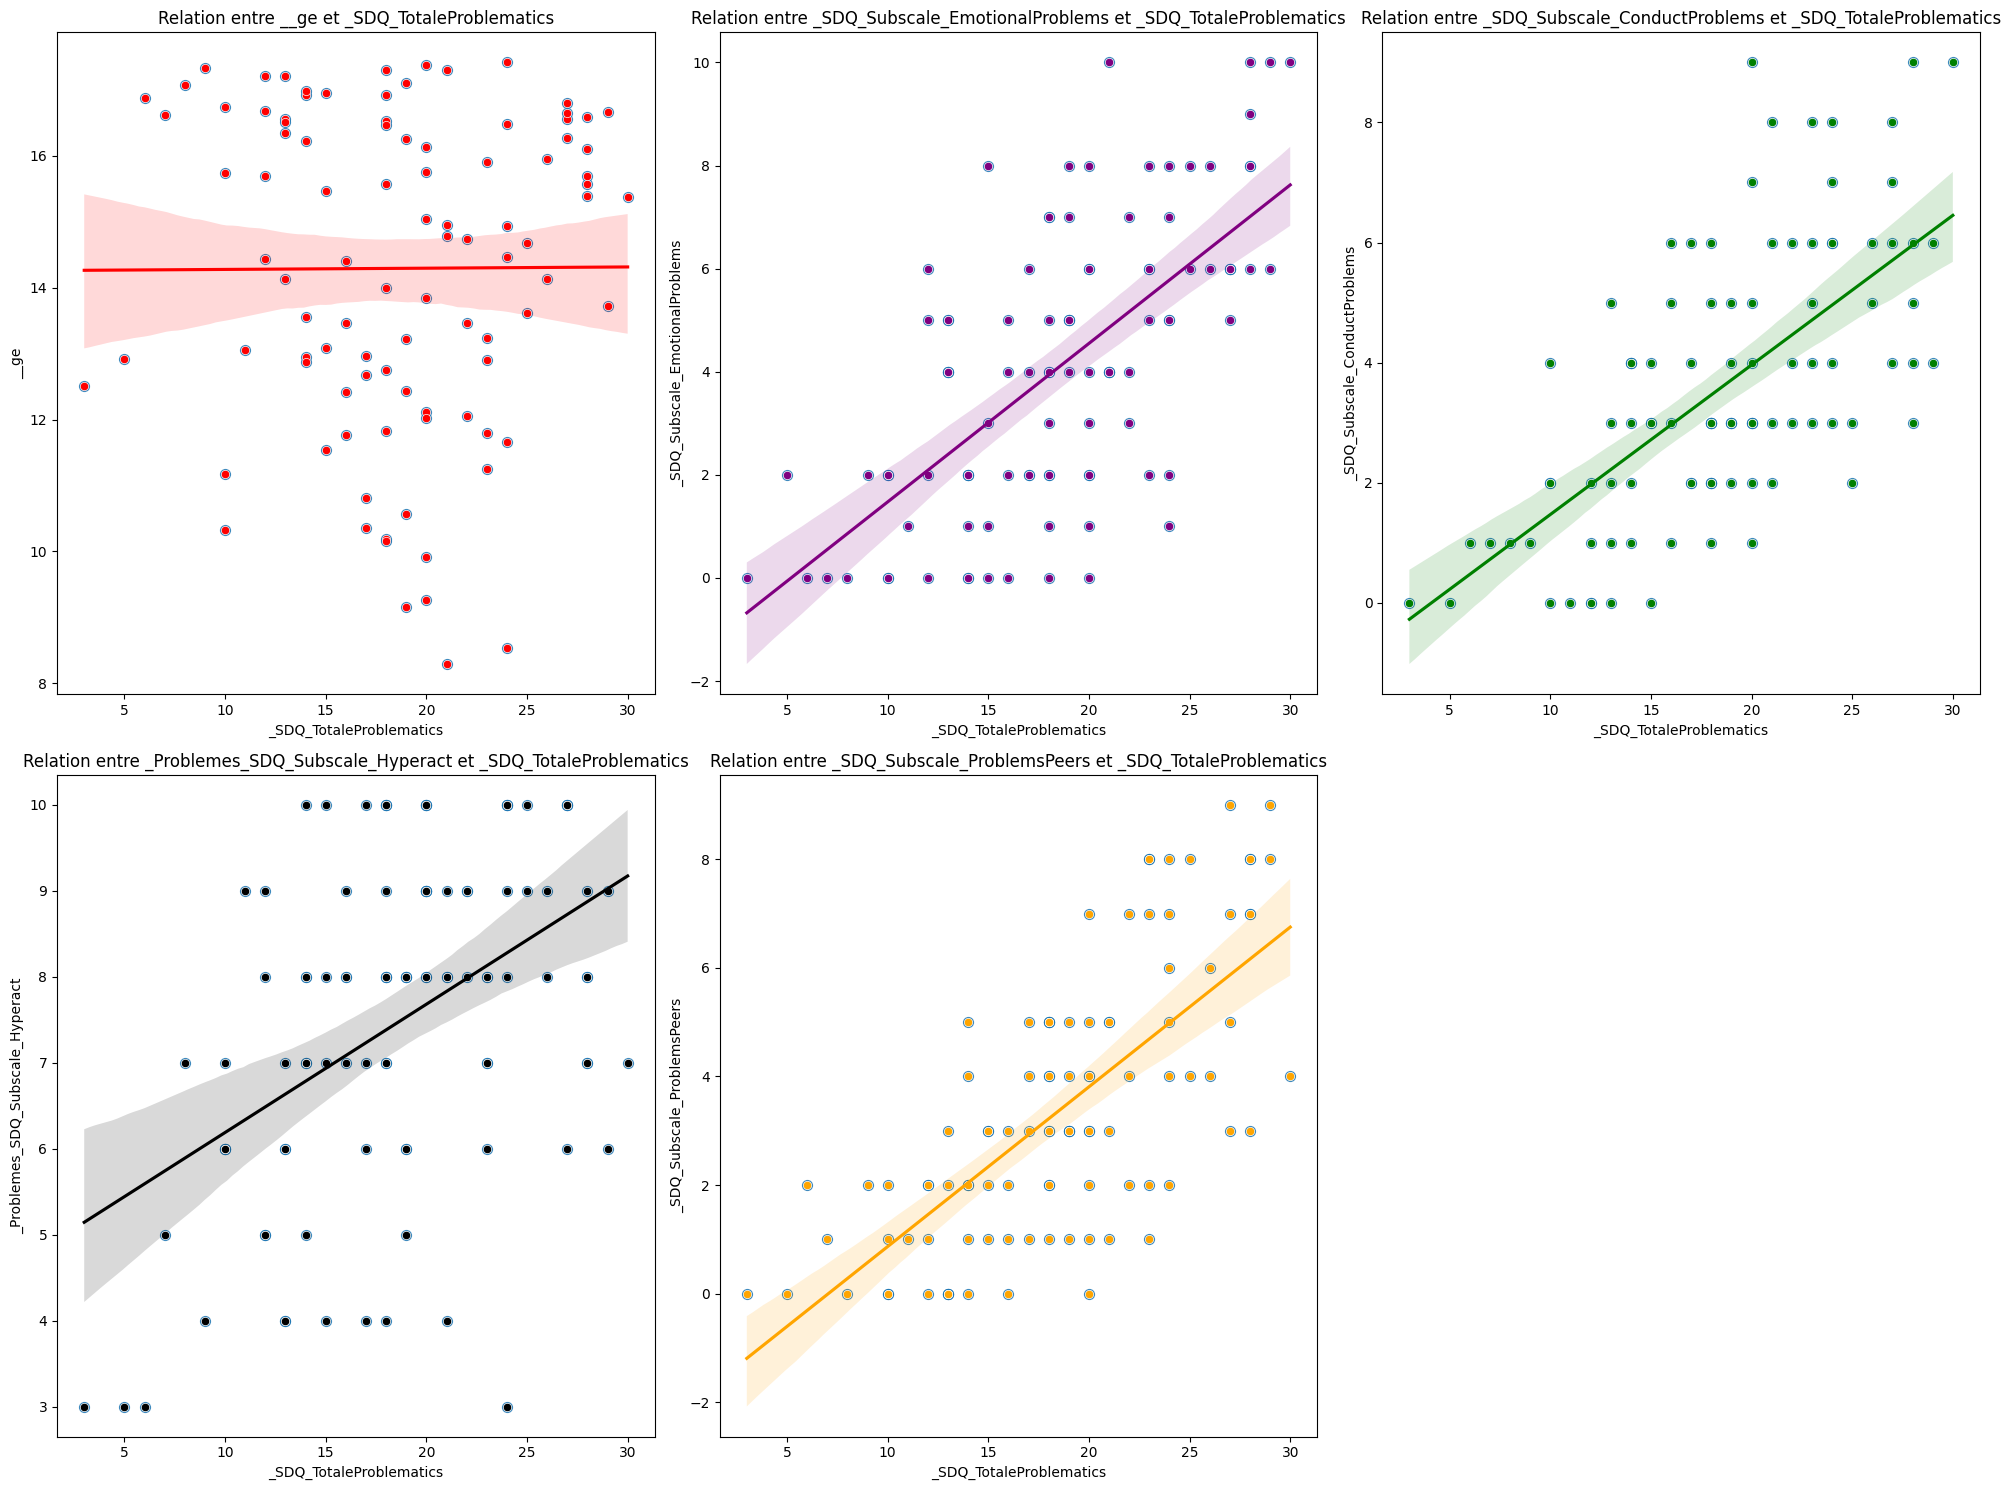

In [19]:
# Variables prédictrices
variables = ['__ge', '_SDQ_Subscale_EmotionalProblems', '_SDQ_Subscale_ConductProblems', '_Problemes_SDQ_Subscale_Hyperact', '_SDQ_Subscale_ProblemsPeers']

# Création des sous-graphes avec une taille de figure plus grande
fig, axes = plt.subplots(2, 3, figsize=(20, 15))

# Couleurs pour chaque variable
colors = ['red', 'purple', 'green', 'black', 'orange']

# Tracé des graphiques
for ax, var, color in zip(axes.flat, variables, colors):
    sns.regplot(x='_SDQ_TotaleProblematics', y=var, data=emo, scatter_kws={'s': 50}, line_kws={'color': color}, ax=ax)
    ax.set_title(f'Relation entre {var} et _SDQ_TotaleProblematics')
    sns.scatterplot(x='_SDQ_TotaleProblematics', y=var, data=emo, color=color, ax=ax)

# Supprimer le sous-graphe vide
fig.delaxes(axes[1, 2])

# Ajustement de l'espacement entre les sous-graphes
plt.tight_layout()
plt.show()


La visualisation graphique sur la relation entre la variable cible et les prédicteurs confirment de plus, les résultats fournis sur la matrice de corrélation.

## 1.5. Normalisation des données

In [20]:
min_max_scaler= MinMaxScaler()
emo_normalized= emo.copy()
emo_normalized[variables]= min_max_scaler.fit_transform(emo[variables])
emo_normalized

,__ge,_SDQ_TotaleProblematics,_SDQ_Subscale_EmotionalProblems,_SDQ_Subscale_ConductProblems,_Problemes_SDQ_Subscale_Hyperact,_SDQ_Subscale_ProblemsPeers
0,0.507119,5,0.2,0.000000,0.000000,0.000000
1,0.577218,14,0.2,0.222222,1.000000,0.000000
2,0.874042,27,0.6,0.888889,1.000000,0.333333
3,0.706462,22,0.4,0.333333,0.714286,0.777778
4,0.817087,20,0.2,0.444444,0.857143,0.555556
...,...,...,...,...,...,...
99,0.355969,15,0.8,0.000000,0.142857,0.333333
100,0.976999,12,0.5,0.222222,0.285714,0.000000
101,0.479737,17,0.2,0.444444,1.000000,0.111111
102,0.506024,23,0.6,0.888889,0.714286,0.111111


## 2. Entraînement et évaluation du modèle

### 2.1. Entraînement du modèle

In [ ]:
# division des données en sous-ensemble d'entraînement et de test
x=emo_normalized.drop(columns=['_SDQ_TotaleProblematics']) # les prédicteurs
y=emo_normalized['_SDQ_TotaleProblematics'] # la variable cible

x_train,x_test,y_train, y_test =t